Load library

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Load data

In [3]:
mnist_data = fetch_openml('mnist_784', version = 1, as_frame = False)
X, y = mnist_data.data, mnist_data.target
X = X.astype(np.float64)
y = y.astype(int)

In [4]:
def display_network(A, m = -1, n = -1):
    """
    This function visualizes filters in matrix A. Each column of A is a
    filter. We will reshape each column into a square image and visualizes
    on each cell of the visualization panel.
    All other parameters are optional, usually you do not need to worry
    about it.
    opt_normalize: whether we need to normalize the filter so that all of
    them can have similar contrast. Default value is true.
    opt_graycolor: whether we use gray as the heat map. Default is true.
    opt_colmajor: you can switch convention to row major for A. In that
    case, each row of A is a filter. Default value is false.
    source: https://github.com/tsaith/ufldl_tutorial
    """
    
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)
        

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0

    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1

    return image

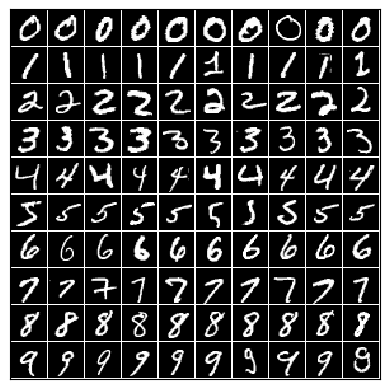

In [5]:
# Data-Visulization
digits = np.arange(10)
A = np.empty((0, X.shape[1]))
for digit in digits:
    digit_ids = X[np.where(y == digit)[0],:]
    A = np.concatenate([A, digit_ids[:10, :]], axis = 0)
    
image = display_network(A.T, m = 10, n = 10)
fig = plt.imshow(image, interpolation = 'nearest', cmap = 'gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

Data-preprocessing

In [6]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data to train set and test set
TEST_SIZE = 10000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, shuffle = True, random_state = 1)

# Data scaling
X_train /= 255.0
X_test /= 255.0

Shape of X: (70000, 784)
Shape of y: (70000,)


Load model

In [7]:
def softmax_stable(Z : np.ndarray) -> np.ndarray:
    """
    Shape of Z : (N,C)
    N: number of points
    C: number of classes
    Compute softmax values for each sets of scores in Z.
    each row of Z is a set of scores.    
    """
    e_Z = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
    A = e_Z / np.sum(e_Z, axis = 1, keepdims = True)
    return A

def crossentropy_loss(Yhat : np.ndarray, y : np.ndarray):
    """
    Yhat: a numpy array of shape (Npoints, nClasses) -- predicted output
    y: a numpy array of shape (Npoints) -- ground truth.
    NOTE: We don’t need to use the one-hot vector here since most of elements
    are zeros. When programming in numpy, in each row of Yhat, we need to access
    to the corresponding index only.
    """
    N = Yhat.shape[0]
    idx_axis_0 = np.arange(N)
    return -np.mean(np.log(Yhat[idx_axis_0, y]))
    

def mlp_init(d0 , d1, d2, d3):
    """
    Initialize W1, b1, W2, b2, W3, b3
    d0: dimension of input data
    d1, d2: number of hidden unit
    d3: number of output unit = number of classes
    """
    W1 = np.random.randn(d0, d1) * np.sqrt(2 / 784)
    b1 = np.zeros(d1)
    W2 = np.random.randn(d1, d2) * np.sqrt(2 / 128)
    b2 = np.zeros(d2)
    W3 = np.random.randn(d2, d3) * np.sqrt(2 / 64)
    b3 = np.zeros(d3)
    return (W1, b1, W2, b2, W3, b3)
    
def mlp_predict(X : np.ndarray, W1 : np.ndarray, b1 : np.ndarray, W2 : np.ndarray, b2 : np.ndarray, W3: np.ndarray, b3 : np.ndarray) -> np.ndarray:
    """
    Suppose that the network has been trained, predict class of new points.
    X: data matrix, each ROW is one data point.
    W1, b1, W2, b2, W3, b3: learned weight matrices and biases
    Return an ndarray of predicted classes for new data points.
    """
    Z1 = (X @ W1) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = (A1 @ W2) + b2
    A2 = np.maximum(Z2, 0)
    Z3 = (A2 @ W3) + b3
    return np.argmax(Z3, axis = 1)
    

def mlp_fit(X_train : np.ndarray, y_train : np.ndarray, W1 : np.ndarray, b1 : np.ndarray, W2 : np.ndarray, b2 : np.ndarray, W3 : np.ndarray, b3 : np.ndarray, eta=0.1, n_epochs=100, batch_size=-1):
    """
    Trains a simple Multi-Layer Perceptron (MLP) model using gradient descent.
    This function updates the weights and biases of a two-layer neural network using a given learning rate. The MLP consists of:
    - An input layer
    - One hidden layer with ReLU
    - An output layer with Softmax

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        y (np.ndarray): Target labels of shape (n_samples, ).
        W1,W2,W3 (np.ndarray): Weight matrix of shape (d(l-1), d(l)).
        b1,b2,b3 (np.ndarray): Bias vector (d(l), ).
        eta (float): Learning rate used for weight updates.
    """
    loss_hist = []
    
    N = X_train.shape[0]
    batch_size = N if (batch_size == -1) else batch_size
    n_batches = int(np.ceil(float(N)/batch_size))
    
    progress_bar = tqdm(range(n_epochs), desc="Epochs progress")
    for epoch in progress_bar:
        # Mini-Batch Gradient Descent
        idx = np.random.permutation(N)
        for ith in range(n_batches):
            batch_idx = idx[batch_size*ith : min(batch_size*(ith + 1), N)]
            X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
        
            # Feedforward
            Z1 = (X_batch @ W1) + b1
            A1 = np.maximum(Z1, 0)  # ReLU activation
            Z2 = (A1 @ W2) + b2
            A2 = np.maximum(Z2, 0)  # ReLU activation
            Z3 = (A2 @ W3) + b3
            A3 = softmax_stable(Z3) # Softmax activation
            
            Yhat = A3
            loss_cur = crossentropy_loss(Yhat, y_batch)
            loss_hist.append(loss_cur)
            
            # Backpropagation
            idx_axis_0 = np.arange(Yhat.shape[0])
            Y = np.zeros_like(Yhat, dtype = np.float32)
            Y[idx_axis_0, y_batch] = 1
            E3 = (1/Yhat.shape[0])*(Yhat - Y)       # shape (N, d3)
            dW3 = (A2.T @ E3)                       # shape (d2, d3)
            db3 = np.sum(E3, axis = 0)              # shape (d3, 1)
            
            E2 = (E3 @ W3.T)                        # shape (N, d2)
            E2[Z2 <= 0]  = 0                        # gradient of ReLU, shape (N, d2)
            dW2 = (A1.T @ E2)                       # shape (d1, d2)
            db2 = np.sum(E2, axis = 0)              # shape (d2, 1)
            
            E1 = (E2 @ W2.T)                        # shape (N, d1)
            E1[Z1 <= 0] = 0                         # gradient of ReLU, shape (N, d1)
            dW1 = (X_batch.T @ E1)                  # shape (d0, d1)
            db1 = np.sum(E1, axis = 0)              # shape (d1, 1)
            
            # Gradient Descent update
            W1 -= eta*dW1
            b1 -= eta*db1
            W2 -= eta*dW2
            b2 -= eta*db2
            W3 -= eta*dW3
            b3 -= eta*db3
            
        progress_bar.set_postfix(loss=f"{loss_cur:.6f}")
        
    return (W1, b1, W2, b2, W3, b3, loss_hist)

In [8]:
d0 = 784    # data dimension
d1 = 128    # number of hidden units
d2 = 64     # number of hidden units
d3 = C = 10     # number of classes
(W1, b1, W2, b2, W3, b3) = mlp_init(d0, d1, d2, d3)
(W1, b1, W2, b2, W3, b3, loss_hist) = mlp_fit(X_train, y_train, W1, b1, W2, b2, W3, d3, eta = 0.1, batch_size = 1000)

Epochs progress: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s, loss=0.030210]


In [9]:
def accuracy_score(y_test : np.ndarray, y_pred : np.ndarray):
    return np.mean(y_test == y_pred)

y_pred = mlp_predict(X_test, W1, b1, W2, b2, W3, b3)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%")

Accuracy score: 97.69%


Using Sklearn

In [10]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver = 'adam', alpha = 0.00001, hidden_layer_sizes = (128))
model.fit(X_train, y_train)
print(f"Accuracy score: {np.mean(y_test == model.predict(X_test))*100:.2f} %")

Accuracy score: 97.89 %


Display misclassified-images

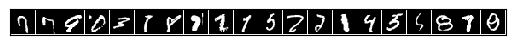

[9 4 0 3 5 7 4 8 3 1 3 7 7 8 9 3 4 2 7 9]


In [16]:
idx_misclassified = np.where((y_test != y_pred))[0]
P = X_test[idx_misclassified[:20]]

image = display_network(P.T, m = 1, n = 20)
fig = plt.imshow(image, interpolation = 'nearest', cmap = 'gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()
print(y_pred[idx_misclassified[:20]])